In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("data/technical/sales_train.csv")
feature_names = ['date_block_num', 'shop_id', 'item_id', 'item_price']
df_features = df_train[feature_names]

In [3]:
mse = False  # set `True` for MSE, `False` for RMSE

Check if any `NaN` values are in the dataset.

In [4]:
df_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

# Check Correlation between the features

[Source for the formatting](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec)

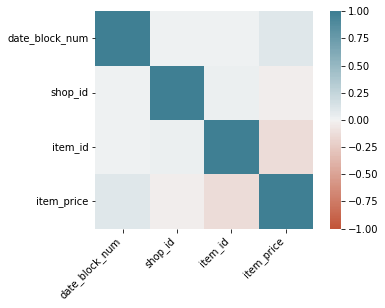

In [5]:
corr = df_features.corr()

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);  # the ';' suppresses the output

**Little to no correlation found between the features:**

`item_id` gives us a negative correlation, which is to be expected.

The only tiny correlation to be found is regarding the price of the item.
`item_price` shows the darkest spot on the graph.

Cite correlation interpretation: `978-1-4614-7138-7` - p. 156


# Boxplot: that a closer look at `item_price`

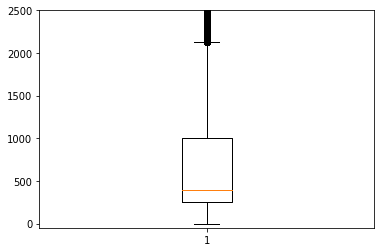

In [6]:
fig1, ax1 = plt.subplots()
ax1.boxplot(df_features['item_price'])
plt.ylim([-50, 2500])
plt.show()

Get a grip of the price at hand by converting it to a familiar currency.

In [7]:
from currency_converter import CurrencyConverter
from datetime import date

c = CurrencyConverter()

rub_in_usd = int(c.convert(500, 'RUB', 'USD', date=date(2014, 7, 1)))

print(f"500 RUB is approx. equal to {rub_in_usd} USD "
      f"at the time of the data.")


500 RUB is approx. equal to 14 USD at the time of the data.


# Linear regression

Start off with a simple application of a simple linear regression model

In [8]:
# first, define our class we are going to use a few times

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class MyLR:

    def __init__(self, x, y):
        """Pass `X_train` and `Y_train` to the constructor"""
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.20, random_state=1)
        self.LR = LinearRegression()
        self.LR.fit(self.x_train, self.y_train)

        self.train_set_rmse = mean_squared_error(self.y_train, self.LR.predict(self.x_train), squared=mse)
        self.test_set_rmse = mean_squared_error(self.y_test, self.LR.predict(self.x_test), squared=mse)
        self.test_set_score = self.LR.score(self.x_train,self.y_train)

    def print(self):
        print('Train set rmse:', self.train_set_rmse)
        print('Test set rmse:', self.test_set_rmse)
        print('Test set score:', self.test_set_score)

In [9]:
Y_train = df_train['item_cnt_day']
X_train = df_train[feature_names]

In [10]:
MyLR(X_train, Y_train).print()

Train set rmse: 2.322206078154416
Test set rmse: 3.5639661191093497
Test set score: 0.0007086413604801001


The results do not look at all promising. Never use the test data during training.

Off to a new start.

In [11]:
# FIXME: found an issue with the formatting of the date
# first, format the date to be regrouped into months

def format_timestrings_in_pd(pd_to_format):
    pd_to_format['date'] = pd.to_datetime(pd_to_format['date'], dayfirst=True)
    pd_to_format['date'] = pd_to_format['date'].apply(lambda x: x.strftime('%Y-%m'))
    return pd_to_format

df_train = format_timestrings_in_pd(df_train)

In [13]:
# parse all the months in the list to iterate them
# for later feature engineering

def col_is_year(col):
    return col[0] == '2'

def get_all_months(merged_frame):
    all_cols = set(merged_frame.columns.values.tolist())
    cols_to_remove = set()
    for col in all_cols:
        if not col_is_year(col):
            cols_to_remove.add(col)
    final_col = all_cols - cols_to_remove
    final_col = list(final_col)
    final_col.sort()
    return final_col

In [14]:
# then, sum up the sales according to their categories
df = df_train.groupby(['date','shop_id','item_id']).sum()
df = df.pivot_table(index=['shop_id','item_id'], columns='date', values='item_cnt_day', fill_value=0)
df.reset_index(inplace=True)

all_months = get_all_months(df)

df_pivoted = df

# assign train and test from within the train set
# drop october 2014 from the set and assign it was test values
drop_year = '2014-10'
Y_train = df_pivoted[drop_year].values
X_train = df_pivoted.drop([drop_year], axis=1)

df_pivoted = df

In [15]:
MyLR(X_train, Y_train).print()

Train set rmse: 2.4113022745555877
Test set rmse: 2.0719456183279235
Test set score: 0.5540276005502269


That looked a little better. Now lets find out which month is best dropped

In [16]:
highscore = (0, None)

for month in all_months:

    Y_train = df_pivoted[month].values
    X_train = df_pivoted.drop([month], axis=1)

    df_pivoted = df
    lr = MyLR(X_train, Y_train)
    if lr.test_set_score > highscore[0]:
        highscore = (lr.test_set_score, month)

print(highscore)

(0.8899910007221387, '2014-12')


In [17]:
Y_train = df_pivoted[highscore[1]].values
X_train = df_pivoted.drop([highscore[1]], axis=1)
df_pivoted = df
lr = MyLR(X_train, Y_train)
lr.print()

Train set rmse: 1.6339305830431743
Test set rmse: 1.5215913280633677
Test set score: 0.8899910007221387


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
train_X_scaled = scaler.transform(X_train)

MyLR(X_train, Y_train).print()


Train set rmse: 1.6339305830431743
Test set rmse: 1.5215913280633677
Test set score: 0.8899910007221387


# Test

Now off to add the testing data.

The features missing in the missing data are the month to predict (`2015-11`)
as well as the item price. The item price would be calculated by averaging the
past prices for a given item.

In [19]:
# TODO: wip
df_test = pd.read_csv("data/technical/test.csv")